### Using tensorflow and neural networks to solve the homework 3 problem.

In [1]:
import collections
import os, shutil
import numpy as np
import pandas as pd

import tempfile
import logging

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import tensorflow as tf
print("Tensorflow is installed and is version: ",  tf.__version__)

%matplotlib inline

Tensorflow is installed and is version:  1.3.0


In [2]:
def readData():
    test = pd.read_csv('test_data.csv')
    train = pd.read_csv('train_data.csv')
    return train, test

In [3]:
train_df, test_df = readData()

In [4]:
print('Training data has %d observations with %d features' % train_df.shape)
train_df.head()

Training data has 4584 observations with 670 features


,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,z217,z218,z219,z220,z221,z222,subject,phase,state,output
0,0,0,0,1,-300.361218,0.886360,-2.590886,225.001899,0.006204,0.000037,...,0.005242,0.024971,-1017.620978,-382.850838,-48.275711,-2.040336,A,3,B,0
1,0,0,0,1,-297.126090,0.622211,-3.960940,220.179017,0.006167,-0.000014,...,0.001722,0.023595,91.229094,24.802230,1.783950,0.022620,A,3,C,0
2,0,0,0,1,-236.460253,0.423640,-12.656341,139.453445,0.006276,-0.000028,...,-0.010894,-0.036318,-188.232347,-17.474861,-1.005571,-0.021628,A,3,B,0
3,0,0,0,1,33.411458,2.854415,-1.962432,3.208911,0.009752,-0.000273,...,-0.034184,-0.047734,185.122907,-549.282067,542.193381,-178.049926,A,3,A,0
4,0,0,0,1,-118.125214,2.009809,-3.291637,34.874176,0.007598,0.000001,...,0.001963,0.004084,35.207794,-78.143166,57.084208,-13.700212,A,4,C,0


In [5]:
print('Test data has %d observations with %d features' % test_df.shape)
test_df.head()

Test data has 1732 observations with 669 features


,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,z216,z217,z218,z219,z220,z221,z222,subject,phase,state
0,0,0,0,1,-18.839131,2.306584,-4.655889,1.013324,0.007153,0.000055,...,0.002809,0.014684,0.008373,325.428102,-821.094825,689.695558,-192.867397,B,1,B
1,0,0,0,1,-21.203051,2.112956,-2.503654,1.233657,0.007674,0.000025,...,0.001450,-0.012349,-0.029579,377.365602,-943.446587,785.687687,-217.952016,B,1,C
2,0,0,0,1,-83.843508,2.097191,-2.625699,17.607247,0.007290,0.000077,...,-0.024253,-0.014029,-0.015090,564.866863,-1445.004242,1231.304590,-349.493698,B,1,C
3,0,0,0,1,-192.522878,0.605105,-2.468908,92.456149,0.006284,0.000007,...,0.019957,-0.037490,0.002925,-552.398720,1163.146256,-816.945306,191.395611,B,1,C
4,0,0,0,1,-188.095799,0.390008,-4.870923,88.257844,0.007859,-0.000058,...,0.007063,-0.007101,0.025921,-860.687432,1838.968578,-1310.372483,311.393705,B,1,C


Split into training / validation data sets

In [6]:
train_df, valid_df = train_test_split(train_df, stratify = train_df.output, test_size = 0.20, random_state=100)

In [7]:
train_df = train_df.copy().reset_index(drop = True)
y_train = train_df.output
train_df.drop('output', axis = 1, inplace=True)

In [8]:
valid_df = valid_df.copy().reset_index(drop = True)
y_valid = valid_df.output
valid_df.drop('output', axis = 1, inplace=True)

Scale the numerical features to zero mean and unit variance

In [9]:
scaler = StandardScaler()
scaler = scaler.fit(train_df.iloc[:, :-3])

In [10]:
X_train = scaler.transform(train_df.iloc[:, :-3])
X_train = pd.DataFrame(X_train, columns = train_df.columns[:-3])
X_train['subject'] = train_df.subject
X_train['phase'] = train_df.phase
X_train['state'] = train_df.state

In [11]:
X_valid = scaler.transform(valid_df.iloc[:, :-3])
X_valid = pd.DataFrame(X_valid, columns = valid_df.columns[:-3])
X_valid['subject'] = valid_df.subject
X_valid['phase'] = valid_df.phase
X_valid['state'] = valid_df.state

In [12]:
X_test = scaler.transform(test_df.iloc[:, :-3])
X_test = pd.DataFrame(X_test, columns = test_df.columns[:-3])
X_test['subject'] = test_df.subject
X_test['phase'] = test_df.phase
X_test['state'] = test_df.state

Prepare feature definitions for the tensorflow models

In [13]:
# categorical features
subject = tf.feature_column.categorical_column_with_vocabulary_list(
    key = "subject", 
    vocabulary_list=('A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'k', 'L', 'M'))
phase = tf.feature_column.categorical_column_with_identity(key='phase', num_buckets=10)
state = tf.feature_column.categorical_column_with_vocabulary_list(
    key='state', 
    vocabulary_list=('A', 'B', 'C', 'D', 'E'))
categorical_features = [
    tf.feature_column.indicator_column(subject), 
    tf.feature_column.indicator_column(phase), 
    tf.feature_column.indicator_column(state)
]

In [14]:
# numerical features
numerical_features = []
for i in np.arange(1, 223):
    numerical_features.append(tf.feature_column.numeric_column('x%d'%i))
    numerical_features.append(tf.feature_column.numeric_column('y%d'%i))
    numerical_features.append(tf.feature_column.numeric_column('z%d'%i))

In [15]:
# crossed features
subject_phase = tf.feature_column.crossed_column(["subject", "phase"], hash_bucket_size=100)
crossed_features = [
    tf.feature_column.indicator_column(subject_phase) 
]

In [16]:
print('Training data has %d observations with %d features' % X_train.shape)
print('Validation data has %d observations with %d features' % X_valid.shape)

Training data has 3667 observations with 669 features
Validation data has 917 observations with 669 features


#### Logistic regression tensorflow style  
Cross validate the model to find the best regularization parameter. 

In [17]:
results = []
regularization = [1.0, 10.0, 100.0, 1000.0]

for l1_r in regularization:
    shutil.rmtree('tmp_model',  ignore_errors=True)
    m = tf.estimator.LinearClassifier(
        model_dir = 'tmp_model',
        optimizer=tf.train.FtrlOptimizer(learning_rate=0.01, l1_regularization_strength=l1_r),
        feature_columns = numerical_features + categorical_features + crossed_features
    )    
    m = m.train(
        input_fn=tf.estimator.inputs.pandas_input_fn(
            x = X_train, y = y_train, batch_size = 256, num_epochs = 10, shuffle = True))
    r = m.evaluate(
        input_fn=tf.estimator.inputs.pandas_input_fn(
            x = X_valid, y = y_valid, batch_size = 256, num_epochs = 1, shuffle = False))
    results.append(r)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_steps': None, '_session_config': None, '_model_dir': 'tmp_model', '_save_checkpoints_secs': 600, '_save_summary_steps': 100, '_tf_random_seed': 1, '_keep_checkpoint_max': 5, '_log_step_count_steps': 100, '_keep_checkpoint_every_n_hours': 10000}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into tmp_model\model.ckpt.
INFO:tensorflow:step = 1, loss = 177.446
INFO:tensorflow:global_step/sec: 4.07963
INFO:tensorflow:step = 101, loss = 115.217 (24.513 sec)
INFO:tensorflow:Saving checkpoints for 144 into tmp_model\model.ckpt.
INFO:tensorflow:Loss for final step: 25.7426.
INFO:tensorflow:Starting evaluation at 2017-11-03-17:50:53
INFO:tensorflow:Restoring parameters from tmp_model\model.ckpt-144
INFO:tensorflow:Finished evaluation at 2017-11-03-17:51:08
INFO:tensorflow:Saving dict for global step 144: accuracy = 0.841876, accuracy_baseline = 0.845147, auc = 0.705879, 

In [18]:
accuracy = [r['accuracy'] for r in results]
auc = [r['auc'] for r in results]

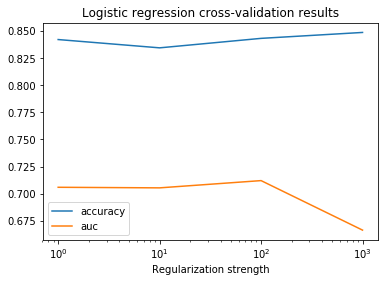

In [19]:
plt.plot(regularization, accuracy, label='accuracy')
plt.plot(regularization, auc, label='auc')
plt.xlabel('Regularization strength')
plt.xscale('log')
plt.title('Logistic regression cross-validation results')
plt.legend()

It is already clear to us the NN-based model is more complex to cross-validate. There is a lot of parameters to chose - batch size, how many epcohs to train on, which optimizer to use, the learning rate. It is also slower to train than a normal logistic regression model.

In [20]:
shutil.rmtree('log_model',  ignore_errors=True)

log_model = tf.estimator.LinearClassifier(
    model_dir = 'log_model',
    # best regularization parameter from the cross-validation
    optimizer=tf.train.FtrlOptimizer(learning_rate=0.1, l1_regularization_strength=100.),
    feature_columns = numerical_features + categorical_features + crossed_features
)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_steps': None, '_session_config': None, '_model_dir': 'log_model', '_save_checkpoints_secs': 600, '_save_summary_steps': 100, '_tf_random_seed': 1, '_keep_checkpoint_max': 5, '_log_step_count_steps': 100, '_keep_checkpoint_every_n_hours': 10000}


In [21]:
log_model.train(
    input_fn=tf.estimator.inputs.pandas_input_fn(
        x = X_train, y = y_train, batch_size = 256, num_epochs = 5, shuffle = False))

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into log_model\model.ckpt.
INFO:tensorflow:step = 1, loss = 177.446
INFO:tensorflow:Saving checkpoints for 72 into log_model\model.ckpt.
INFO:tensorflow:Loss for final step: 56.8861.


In [22]:
log_results = log_model.evaluate(
    input_fn=tf.estimator.inputs.pandas_input_fn(
        x = X_valid, y = y_valid, batch_size = 256, num_epochs = 1, shuffle = False))

INFO:tensorflow:Starting evaluation at 2017-11-03-18:11:06
INFO:tensorflow:Restoring parameters from log_model\model.ckpt-72
INFO:tensorflow:Finished evaluation at 2017-11-03-18:11:23
INFO:tensorflow:Saving dict for global step 72: accuracy = 0.85169, accuracy_baseline = 0.845147, auc = 0.740645, auc_precision_recall = 0.930634, average_loss = 0.382724, global_step = 72, label/mean = 0.845147, loss = 87.7394, prediction/mean = 0.825695


In [23]:
for key in sorted(log_results):
    print("%s: %s" % (key, log_results[key]))

accuracy: 0.85169
accuracy_baseline: 0.845147
auc: 0.740645
auc_precision_recall: 0.930634
average_loss: 0.382724
global_step: 72
label/mean: 0.845147
loss: 87.7394
prediction/mean: 0.825695


In [24]:
log_predict = log_model.predict(
    input_fn=tf.estimator.inputs.pandas_input_fn(
        x = X_test, y = None, batch_size = 256, num_epochs = 1, shuffle = False))

In [25]:
log_results = list(log_predict)

INFO:tensorflow:Restoring parameters from log_model\model.ckpt-72


#### Prepare the Kaggle submission

In [26]:
p_hat = [r['probabilities'][1] for r in log_results]
test_df['output'] = p_hat
test_df[['output']].to_csv('log_solution.csv', index_label = 'id')
test_df.drop('output', inplace = True, axis = 1)

There was not an imporvement on my best submssion score from the random forest model.

#### NN tensorflow style  
Here we try a proper NN based on DNNClassifier class. It gives us an ability to define a deep NN without too much effort but perhaps with limited configuration options.

In [48]:
shutil.rmtree('tmp_model',  ignore_errors=True)

#  defining a 3-layer network is easy
nn_model = tf.estimator.DNNClassifier(
    model_dir = 'tmp_model',
    feature_columns=numerical_features + categorical_features + crossed_features,
    hidden_units=[512, 256, 128],
    n_classes=2
)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_steps': None, '_session_config': None, '_model_dir': 'tmp_model', '_save_checkpoints_secs': 600, '_save_summary_steps': 100, '_tf_random_seed': 1, '_keep_checkpoint_max': 5, '_log_step_count_steps': 100, '_keep_checkpoint_every_n_hours': 10000}


In [49]:
nn_model = nn_model.train(
    input_fn=tf.estimator.inputs.pandas_input_fn(
        x = X_train, y = y_train, batch_size = 256, num_epochs = 20, shuffle = True))

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into tmp_model\model.ckpt.
INFO:tensorflow:step = 1, loss = 171.649
INFO:tensorflow:global_step/sec: 4.98828
INFO:tensorflow:step = 101, loss = 64.8818 (20.048 sec)
INFO:tensorflow:global_step/sec: 5.12636
INFO:tensorflow:step = 201, loss = 42.071 (19.529 sec)
INFO:tensorflow:Saving checkpoints for 287 into tmp_model\model.ckpt.
INFO:tensorflow:Loss for final step: 2.35968.


In [50]:
nn_results = nn_model.evaluate(
    input_fn=tf.estimator.inputs.pandas_input_fn(
        x = X_valid, y = y_valid, batch_size = 256, num_epochs = 1, shuffle = False))
print("-----------------------------------------------------------------------------")
for key in sorted(nn_results):
    print("%s: %s" % (key, nn_results[key]))

INFO:tensorflow:Starting evaluation at 2017-11-03-18:35:53
INFO:tensorflow:Restoring parameters from tmp_model\model.ckpt-287
INFO:tensorflow:Finished evaluation at 2017-11-03-18:35:58
INFO:tensorflow:Saving dict for global step 287: accuracy = 0.848419, accuracy_baseline = 0.845147, auc = 0.728801, auc_precision_recall = 0.941839, average_loss = 0.780472, global_step = 287, label/mean = 0.845147, loss = 178.923, prediction/mean = 0.90286
-----------------------------------------------------------------------------
accuracy: 0.848419
accuracy_baseline: 0.845147
auc: 0.728801
auc_precision_recall: 0.941839
average_loss: 0.780472
global_step: 287
label/mean: 0.845147
loss: 178.923
prediction/mean: 0.90286


it works out of the box but the AUC is slightly down comparing to the logistic regression model. Let's try a simpler network.

In [51]:
shutil.rmtree('tmp_model',  ignore_errors=True)

nn_model = tf.estimator.DNNClassifier(
    model_dir = 'tmp_model',
    feature_columns=numerical_features + categorical_features + crossed_features,
    hidden_units=[256, 128, 64],
    n_classes=2,
)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_steps': None, '_session_config': None, '_model_dir': 'tmp_model', '_save_checkpoints_secs': 600, '_save_summary_steps': 100, '_tf_random_seed': 1, '_keep_checkpoint_max': 5, '_log_step_count_steps': 100, '_keep_checkpoint_every_n_hours': 10000}


In [52]:
nn_model = nn_model.train(
    input_fn=tf.estimator.inputs.pandas_input_fn(
        x = X_train, y = y_train, batch_size = 256, num_epochs = 20, shuffle = True))

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into tmp_model\model.ckpt.
INFO:tensorflow:step = 1, loss = 171.306
INFO:tensorflow:global_step/sec: 5.14642
INFO:tensorflow:step = 101, loss = 63.8433 (19.432 sec)
INFO:tensorflow:global_step/sec: 5.28039
INFO:tensorflow:step = 201, loss = 21.0602 (18.939 sec)
INFO:tensorflow:Saving checkpoints for 287 into tmp_model\model.ckpt.
INFO:tensorflow:Loss for final step: 5.50824.


In [53]:
nn_results = nn_model.evaluate(
    input_fn=tf.estimator.inputs.pandas_input_fn(
        x = X_valid, y = y_valid, batch_size = 256, num_epochs = 1, shuffle = False))
print("-----------------------------------------------------------------------------")
for key in sorted(nn_results):
    print("%s: %s" % (key, nn_results[key]))

INFO:tensorflow:Starting evaluation at 2017-11-03-18:40:38
INFO:tensorflow:Restoring parameters from tmp_model\model.ckpt-287
INFO:tensorflow:Finished evaluation at 2017-11-03-18:40:43
INFO:tensorflow:Saving dict for global step 287: accuracy = 0.842966, accuracy_baseline = 0.845147, auc = 0.731004, auc_precision_recall = 0.939507, average_loss = 0.66199, global_step = 287, label/mean = 0.845147, loss = 151.761, prediction/mean = 0.865723
-----------------------------------------------------------------------------
accuracy: 0.842966
accuracy_baseline: 0.845147
auc: 0.731004
auc_precision_recall: 0.939507
average_loss: 0.66199
global_step: 287
label/mean: 0.845147
loss: 151.761
prediction/mean: 0.865723


We got slightly better AUC on the smaller network, so maybe we are overfitting.

Lets stop earlier (less epochs for the network to see).

In [57]:
shutil.rmtree('tmp_model',  ignore_errors=True)

nn_model = tf.estimator.DNNClassifier(
    model_dir = 'tmp_model',
    feature_columns=numerical_features + categorical_features + crossed_features,
    hidden_units=[256, 128, 64],
    n_classes=2,
)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_steps': None, '_session_config': None, '_model_dir': 'tmp_model', '_save_checkpoints_secs': 600, '_save_summary_steps': 100, '_tf_random_seed': 1, '_keep_checkpoint_max': 5, '_log_step_count_steps': 100, '_keep_checkpoint_every_n_hours': 10000}


In [58]:
nn_model = nn_model.train(
    input_fn=tf.estimator.inputs.pandas_input_fn(
        # 5 epochs instead of 20
        x = X_train, y = y_train, batch_size = 256, num_epochs = 5, shuffle = True))

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into tmp_model\model.ckpt.
INFO:tensorflow:step = 1, loss = 173.588
INFO:tensorflow:Saving checkpoints for 72 into tmp_model\model.ckpt.
INFO:tensorflow:Loss for final step: 50.674.


In [59]:
nn_results = nn_model.evaluate(
    input_fn=tf.estimator.inputs.pandas_input_fn(
        x = X_valid, y = y_valid, batch_size = 256, num_epochs = 1, shuffle = False))
print("-----------------------------------------------------------------------------")
for key in sorted(nn_results):
    print("%s: %s" % (key, nn_results[key]))

INFO:tensorflow:Starting evaluation at 2017-11-03-18:47:22
INFO:tensorflow:Restoring parameters from tmp_model\model.ckpt-72
INFO:tensorflow:Finished evaluation at 2017-11-03-18:47:28
INFO:tensorflow:Saving dict for global step 72: accuracy = 0.845147, accuracy_baseline = 0.845147, auc = 0.733926, auc_precision_recall = 0.934118, average_loss = 0.393438, global_step = 72, label/mean = 0.845147, loss = 90.1956, prediction/mean = 0.881089
-----------------------------------------------------------------------------
accuracy: 0.845147
accuracy_baseline: 0.845147
auc: 0.733926
auc_precision_recall: 0.934118
average_loss: 0.393438
global_step: 72
label/mean: 0.845147
loss: 90.1956
prediction/mean: 0.881089


Not a massive difference. What if we try smaller learning rate and smaller batch size?

In [66]:
shutil.rmtree('tmp_model',  ignore_errors=True)

nn_model = tf.estimator.DNNClassifier(
    model_dir = 'tmp_model',
    feature_columns=numerical_features + categorical_features + crossed_features,
    hidden_units=[256, 128, 64],
    n_classes=2,
    optimizer = tf.train.GradientDescentOptimizer(learning_rate = 0.001)
)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_steps': None, '_session_config': None, '_model_dir': 'tmp_model', '_save_checkpoints_secs': 600, '_save_summary_steps': 100, '_tf_random_seed': 1, '_keep_checkpoint_max': 5, '_log_step_count_steps': 100, '_keep_checkpoint_every_n_hours': 10000}


In [67]:
nn_model = nn_model.train(
    input_fn=tf.estimator.inputs.pandas_input_fn(
        x = X_train, y = y_train, batch_size = 64, num_epochs = 10, shuffle = True))

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into tmp_model\model.ckpt.
INFO:tensorflow:step = 1, loss = 41.068
INFO:tensorflow:global_step/sec: 12.41
INFO:tensorflow:step = 101, loss = 33.5877 (8.080 sec)
INFO:tensorflow:global_step/sec: 12.0817
INFO:tensorflow:step = 201, loss = 16.9164 (8.279 sec)
INFO:tensorflow:global_step/sec: 11.7426
INFO:tensorflow:step = 301, loss = 23.2741 (8.515 sec)
INFO:tensorflow:global_step/sec: 11.6144
INFO:tensorflow:step = 401, loss = 16.6063 (8.609 sec)
INFO:tensorflow:global_step/sec: 11.8299
INFO:tensorflow:step = 501, loss = 9.00706 (8.456 sec)
INFO:tensorflow:Saving checkpoints for 573 into tmp_model\model.ckpt.
INFO:tensorflow:Loss for final step: 10.3796.


In [68]:
nn_results = nn_model.evaluate(
    input_fn=tf.estimator.inputs.pandas_input_fn(
        x = X_valid, y = y_valid, batch_size = 256, num_epochs = 1, shuffle = False))
print("-----------------------------------------------------------------------------")
for key in sorted(nn_results):
    print("%s: %s" % (key, nn_results[key]))

INFO:tensorflow:Starting evaluation at 2017-11-03-18:58:55
INFO:tensorflow:Restoring parameters from tmp_model\model.ckpt-573
INFO:tensorflow:Finished evaluation at 2017-11-03-18:59:00
INFO:tensorflow:Saving dict for global step 573: accuracy = 0.842966, accuracy_baseline = 0.845147, auc = 0.737528, auc_precision_recall = 0.934645, average_loss = 0.45546, global_step = 573, label/mean = 0.845147, loss = 104.414, prediction/mean = 0.865341
-----------------------------------------------------------------------------
accuracy: 0.842966
accuracy_baseline: 0.845147
auc: 0.737528
auc_precision_recall: 0.934645
average_loss: 0.45546
global_step: 573
label/mean: 0.845147
loss: 104.414
prediction/mean: 0.865341


Similar performance. Lets use a better optimizer that can adjust our learning rate accordingly.

In [69]:
shutil.rmtree('tmp_model',  ignore_errors=True)

nn_model = tf.estimator.DNNClassifier(
    model_dir = 'tmp_model',
    feature_columns=numerical_features + categorical_features + crossed_features,
    hidden_units=[256, 128, 64],
    n_classes=2,
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_steps': None, '_session_config': None, '_model_dir': 'tmp_model', '_save_checkpoints_secs': 600, '_save_summary_steps': 100, '_tf_random_seed': 1, '_keep_checkpoint_max': 5, '_log_step_count_steps': 100, '_keep_checkpoint_every_n_hours': 10000}


In [70]:
nn_model = nn_model.train(
    input_fn=tf.estimator.inputs.pandas_input_fn(
        x = X_train, y = y_train, batch_size = 64, num_epochs = 10, shuffle = True))

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into tmp_model\model.ckpt.
INFO:tensorflow:step = 1, loss = 41.7877
INFO:tensorflow:global_step/sec: 12.1921
INFO:tensorflow:step = 101, loss = 21.5559 (8.226 sec)
INFO:tensorflow:global_step/sec: 11.9688
INFO:tensorflow:step = 201, loss = 12.0183 (8.353 sec)
INFO:tensorflow:global_step/sec: 11.9359
INFO:tensorflow:step = 301, loss = 11.473 (8.381 sec)
INFO:tensorflow:global_step/sec: 12.038
INFO:tensorflow:step = 401, loss = 10.6377 (8.305 sec)
INFO:tensorflow:global_step/sec: 8.5019
INFO:tensorflow:step = 501, loss = 13.3235 (11.762 sec)
INFO:tensorflow:Saving checkpoints for 573 into tmp_model\model.ckpt.
INFO:tensorflow:Loss for final step: 5.4964.


In [71]:
nn_results = nn_model.evaluate(
    input_fn=tf.estimator.inputs.pandas_input_fn(
        x = X_valid, y = y_valid, batch_size = 256, num_epochs = 1, shuffle = False))
print("-----------------------------------------------------------------------------")
for key in sorted(nn_results):
    print("%s: %s" % (key, nn_results[key]))

INFO:tensorflow:Starting evaluation at 2017-11-03-19:02:04
INFO:tensorflow:Restoring parameters from tmp_model\model.ckpt-573
INFO:tensorflow:Finished evaluation at 2017-11-03-19:02:09
INFO:tensorflow:Saving dict for global step 573: accuracy = 0.834242, accuracy_baseline = 0.845147, auc = 0.760154, auc_precision_recall = 0.947507, average_loss = 0.710824, global_step = 573, label/mean = 0.845147, loss = 162.956, prediction/mean = 0.849589
-----------------------------------------------------------------------------
accuracy: 0.834242
accuracy_baseline: 0.845147
auc: 0.760154
auc_precision_recall: 0.947507
average_loss: 0.710824
global_step: 573
label/mean: 0.845147
loss: 162.956
prediction/mean: 0.849589


That is a good AUC improvement. Maybe we could do even better if we let the network see our data more times?

In [72]:
shutil.rmtree('tmp_model',  ignore_errors=True)

nn_model = tf.estimator.DNNClassifier(
    model_dir = 'tmp_model',
    feature_columns=numerical_features + categorical_features + crossed_features,
    hidden_units=[256, 128, 64],
    n_classes=2,
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_steps': None, '_session_config': None, '_model_dir': 'tmp_model', '_save_checkpoints_secs': 600, '_save_summary_steps': 100, '_tf_random_seed': 1, '_keep_checkpoint_max': 5, '_log_step_count_steps': 100, '_keep_checkpoint_every_n_hours': 10000}


In [73]:
nn_model = nn_model.train(
    input_fn=tf.estimator.inputs.pandas_input_fn(
        # 15 epochs instead of 10
        x = X_train, y = y_train, batch_size = 64, num_epochs = 15, shuffle = True))

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into tmp_model\model.ckpt.
INFO:tensorflow:step = 1, loss = 42.7406
INFO:tensorflow:global_step/sec: 12.2594
INFO:tensorflow:step = 101, loss = 25.2398 (8.179 sec)
INFO:tensorflow:global_step/sec: 11.7247
INFO:tensorflow:step = 201, loss = 26.5427 (8.529 sec)
INFO:tensorflow:global_step/sec: 8.50195
INFO:tensorflow:step = 301, loss = 8.28508 (11.761 sec)
INFO:tensorflow:global_step/sec: 12.0063
INFO:tensorflow:step = 401, loss = 12.6647 (8.331 sec)
INFO:tensorflow:global_step/sec: 12.0992
INFO:tensorflow:step = 501, loss = 5.6665 (8.264 sec)
INFO:tensorflow:global_step/sec: 11.8963
INFO:tensorflow:step = 601, loss = 2.58963 (8.408 sec)
INFO:tensorflow:global_step/sec: 11.8413
INFO:tensorflow:step = 701, loss = 7.7251 (8.444 sec)
INFO:tensorflow:global_step/sec: 12.0077
INFO:tensorflow:step = 801, loss = 4.92599 (8.329 sec)
INFO:tensorflow:Saving checkpoints for 860 into tmp_model\model.ckpt.
INFO:tenso

In [74]:
nn_results = nn_model.evaluate(
    input_fn=tf.estimator.inputs.pandas_input_fn(
        x = X_valid, y = y_valid, batch_size = 256, num_epochs = 1, shuffle = False))
print("-----------------------------------------------------------------------------")
for key in sorted(nn_results):
    print("%s: %s" % (key, nn_results[key]))

INFO:tensorflow:Starting evaluation at 2017-11-03-19:06:53
INFO:tensorflow:Restoring parameters from tmp_model\model.ckpt-860
INFO:tensorflow:Finished evaluation at 2017-11-03-19:06:59
INFO:tensorflow:Saving dict for global step 860: accuracy = 0.844057, accuracy_baseline = 0.845147, auc = 0.780132, auc_precision_recall = 0.954262, average_loss = 0.830995, global_step = 860, label/mean = 0.845147, loss = 190.506, prediction/mean = 0.846936
-----------------------------------------------------------------------------
accuracy: 0.844057
accuracy_baseline: 0.845147
auc: 0.780132
auc_precision_recall: 0.954262
average_loss: 0.830995
global_step: 860
label/mean: 0.845147
loss: 190.506
prediction/mean: 0.846936


That is great, the AUC went up. I shall try this model on the Kaggle competition.

In [75]:
nn_predict = nn_model.predict(
    input_fn=tf.estimator.inputs.pandas_input_fn(x = X_test, y = None, batch_size = 256, num_epochs = 1, shuffle = False))

In [76]:
nn_results = list(nn_predict)

INFO:tensorflow:Restoring parameters from tmp_model\model.ckpt-860


In [77]:
p_hat = [r['probabilities'][1] for r in nn_results]
test_df['output'] = p_hat
test_df[['output']].to_csv('nn_solution.csv', index_label = 'id')
test_df.drop('output', inplace = True, axis = 1)

There was not an imporvement on my best submssion score and it looks like the model is overfitting (test AUC was much smaller). Lets regularize our model.

In [90]:
# regularize the model with dropouts
# in this model the dropout parameter is the probability we will drop out a given coordinate
# smaller dropout -> less regularization
dropouts = [0.3, 0.4, 0.5, 0.6, 0.7]
results = []
for dropout in dropouts:
    
    shutil.rmtree('tmp_model',  ignore_errors=True)
    
    m = tf.estimator.DNNClassifier(
        model_dir = 'tmp_model',
        feature_columns=numerical_features + categorical_features + crossed_features,
        hidden_units=[256, 128, 64],
        dropout = dropout,
        n_classes=2,
        optimizer = tf.train.AdamOptimizer()
    )    
    m = m.train(
        input_fn=tf.estimator.inputs.pandas_input_fn(
            x = X_train, y = y_train, batch_size = 64, num_epochs = 15, shuffle = True))
    r = m.evaluate(
        input_fn=tf.estimator.inputs.pandas_input_fn(
            x = X_valid, y = y_valid, batch_size = 256, num_epochs = 1, shuffle = False))
    results.append(r)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_steps': None, '_session_config': None, '_model_dir': 'tmp_model', '_save_checkpoints_secs': 600, '_save_summary_steps': 100, '_tf_random_seed': 1, '_keep_checkpoint_max': 5, '_log_step_count_steps': 100, '_keep_checkpoint_every_n_hours': 10000}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into tmp_model\model.ckpt.
INFO:tensorflow:step = 1, loss = 61.9264
INFO:tensorflow:global_step/sec: 11.6796
INFO:tensorflow:step = 101, loss = 28.9222 (8.585 sec)
INFO:tensorflow:global_step/sec: 11.3085
INFO:tensorflow:step = 201, loss = 33.1646 (8.857 sec)
INFO:tensorflow:global_step/sec: 11.3534
INFO:tensorflow:step = 301, loss = 23.0083 (8.796 sec)
INFO:tensorflow:global_step/sec: 11.2159
INFO:tensorflow:step = 401, loss = 21.7299 (8.918 sec)
INFO:tensorflow:global_step/sec: 11.3482
INFO:tensorflow:step = 501, loss = 19.63 (8.808 sec)
INFO:tensorflow:global_step/sec: 11.

INFO:tensorflow:global_step/sec: 11.7619
INFO:tensorflow:step = 101, loss = 49.4705 (8.527 sec)
INFO:tensorflow:global_step/sec: 10.9111
INFO:tensorflow:step = 201, loss = 26.9082 (9.153 sec)
INFO:tensorflow:global_step/sec: 11.152
INFO:tensorflow:step = 301, loss = 32.6905 (8.981 sec)
INFO:tensorflow:global_step/sec: 11.2575
INFO:tensorflow:step = 401, loss = 29.4895 (8.905 sec)
INFO:tensorflow:global_step/sec: 11.1894
INFO:tensorflow:step = 501, loss = 31.464 (8.915 sec)
INFO:tensorflow:global_step/sec: 11.3109
INFO:tensorflow:step = 601, loss = 38.6596 (8.838 sec)
INFO:tensorflow:global_step/sec: 11.2233
INFO:tensorflow:step = 701, loss = 33.7783 (8.911 sec)
INFO:tensorflow:global_step/sec: 11.2259
INFO:tensorflow:step = 801, loss = 32.4527 (8.905 sec)
INFO:tensorflow:Saving checkpoints for 860 into tmp_model\model.ckpt.
INFO:tensorflow:Loss for final step: 19.7501.
INFO:tensorflow:Starting evaluation at 2017-11-03-21:37:22
INFO:tensorflow:Restoring parameters from tmp_model\model.c

In [91]:
accuracy = [r['accuracy'] for r in results]
auc = [r['auc'] for r in results]

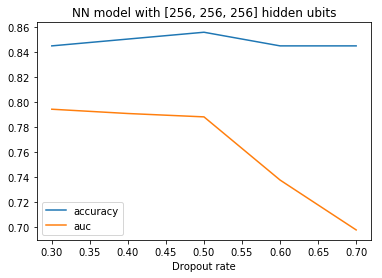

In [92]:
plt.plot(dropouts, accuracy, label='accuracy')
plt.plot(dropouts, auc, label='auc')
plt.xlabel('Dropout rate')
plt.title('NN model with [256, 256, 256] hidden ubits')
plt.legend()

Lets try 0.3 dropout

In [101]:
shutil.rmtree('nn_model',  ignore_errors=True)

nn_model = tf.estimator.DNNClassifier(
    model_dir = 'nn_model',
    feature_columns=numerical_features + categorical_features + crossed_features,
    hidden_units=[256, 128, 64],
    n_classes=2,
    dropout = 0.3,
    optimizer = tf.train.AdamOptimizer()
)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_steps': None, '_session_config': None, '_model_dir': 'nn_model', '_save_checkpoints_secs': 600, '_save_summary_steps': 100, '_tf_random_seed': 1, '_keep_checkpoint_max': 5, '_log_step_count_steps': 100, '_keep_checkpoint_every_n_hours': 10000}


In [102]:
nn_model = nn_model.train(
    input_fn=tf.estimator.inputs.pandas_input_fn(
        x = X_train, y = y_train, batch_size = 64, num_epochs = 15, shuffle = True))

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into nn_model\model.ckpt.
INFO:tensorflow:step = 1, loss = 59.2754
INFO:tensorflow:global_step/sec: 11.7
INFO:tensorflow:step = 101, loss = 22.9467 (8.567 sec)
INFO:tensorflow:global_step/sec: 11.4732
INFO:tensorflow:step = 201, loss = 22.7593 (8.720 sec)
INFO:tensorflow:global_step/sec: 11.3636
INFO:tensorflow:step = 301, loss = 14.2054 (8.804 sec)
INFO:tensorflow:global_step/sec: 11.4824
INFO:tensorflow:step = 401, loss = 21.9978 (8.704 sec)
INFO:tensorflow:global_step/sec: 11.383
INFO:tensorflow:step = 501, loss = 20.2799 (8.786 sec)
INFO:tensorflow:global_step/sec: 11.3895
INFO:tensorflow:step = 601, loss = 24.0107 (8.778 sec)
INFO:tensorflow:global_step/sec: 11.4351
INFO:tensorflow:step = 701, loss = 13.3417 (8.745 sec)
INFO:tensorflow:global_step/sec: 11.422
INFO:tensorflow:step = 801, loss = 8.68458 (8.757 sec)
INFO:tensorflow:Saving checkpoints for 860 into nn_model\model.ckpt.
INFO:tensorflow:

In [103]:
nn_results = nn_model.evaluate(
    input_fn=tf.estimator.inputs.pandas_input_fn(
        x = X_valid, y = y_valid, batch_size = 256, num_epochs = 1, shuffle = False))
print("-----------------------------------------------------------------------------")
for key in sorted(nn_results):
    print("%s: %s" % (key, nn_results[key]))

INFO:tensorflow:Starting evaluation at 2017-11-03-21:58:24
INFO:tensorflow:Restoring parameters from nn_model\model.ckpt-860
INFO:tensorflow:Finished evaluation at 2017-11-03-21:58:30
INFO:tensorflow:Saving dict for global step 860: accuracy = 0.832061, accuracy_baseline = 0.845147, auc = 0.782558, auc_precision_recall = 0.950558, average_loss = 0.456574, global_step = 860, label/mean = 0.845147, loss = 104.67, prediction/mean = 0.81739
-----------------------------------------------------------------------------
accuracy: 0.832061
accuracy_baseline: 0.845147
auc: 0.782558
auc_precision_recall: 0.950558
average_loss: 0.456574
global_step: 860
label/mean: 0.845147
loss: 104.67
prediction/mean: 0.81739


#### Prepare the Kaggle submission

In [104]:
nn_predict = nn_model.predict(
    input_fn=tf.estimator.inputs.pandas_input_fn(x = X_test, y = None, batch_size = 256, num_epochs = 1, shuffle = False))

In [105]:
nn_results = list(nn_predict)

INFO:tensorflow:Restoring parameters from nn_model\model.ckpt-860


In [106]:
p_hat = [r['probabilities'][1] for r in nn_results]
test_df['output'] = p_hat
test_df[['output']].to_csv('nn_solution.csv', index_label = 'id')
test_df.drop('output', inplace = True, axis = 1)

Unfortunately the score was not an improvement on the non-regularized model.

#### Custom NN model
Custom NN model with a special loss function to deal with the class imbalance. The positive class loss is reduced proportionally.  Also a good opprotunity to learn how to create a custom model based on the tf.estimator.Estimator class. it is  more flexible than the DNNClassifier. Here for example we als added batch normalization layers.

In [135]:
def custom_model_fn(features, labels, mode, params, config):

    input_layer = tf.feature_column.input_layer(
        features = features,
        feature_columns = numerical_features + categorical_features + crossed_features
    )
    
    training = (mode == tf.estimator.ModeKeys.TRAIN)

    global_step = tf.contrib.framework.get_or_create_global_step()

    x = tf.layers.dense(
        inputs=input_layer,
        units=256,
        activation=None,
        name="layer1"
    )
    
    x = tf.layers.batch_normalization(
        inputs=x,
        training = training,
        name='bn12'
    )

    x = tf.nn.relu(x, name='relu112')

    x = tf.layers.dropout(
        inputs=x,
        rate = params.dropout,
        training = training,
        name="dropout12"
    )

    x = tf.layers.dense(
        inputs=x,
        units=128,
        activation=None,
        name="layer2"
    )
    
    x = tf.layers.batch_normalization(
        inputs=x,
        training = training,
        name='bn23'
    )

    x = tf.nn.relu(x, name='relu23')

    x = tf.layers.dropout(
        inputs=x,
        rate = params.dropout,
        training = training,
        name="dropout23"
    )

    x = tf.layers.dense(
        inputs=x,
        units=64,
        activation=None,
        name="layer3"
    )

    x = tf.layers.batch_normalization(
        inputs=x,
        training = training,
        name='bn34'
    )
    
    x = tf.nn.relu(x, name='relu34')

    x = tf.layers.dropout(
        inputs=x,
        rate = params.dropout,
        training = training,
        name="dropout34"
    )

    # logits for two classes
    logits = tf.layers.dense(
        inputs=x, 
        units=2, 
        activation=None
    )

    predictions = {
        "classes": tf.argmax(input=logits, axis=1),
        "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    # convert labels into one-hot encodinf array
    # label = o, array element = [1, 0]
    # label = 1, array element = [0, 1]
    targets = tf.one_hot(indices=tf.cast(labels, tf.int32), depth=2)
    
    loss = tf.reduce_mean(
        tf.nn.weighted_cross_entropy_with_logits(
            targets = targets,
            logits = logits,
            pos_weight = 0.2  # penalize the dominating class
        )
    )

    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer()
        train_op = optimizer.minimize(loss=loss, global_step = tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op = train_op)

    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy(labels=labels, predictions=predictions["classes"]),
        "auc": tf.metrics.auc(labels=labels, predictions=predictions["probabilities"][:, 1]),
        "false_negatives": tf.metrics.false_negatives(labels=labels, predictions=predictions["classes"]),
        "false_positives": tf.metrics.false_positives(labels=labels, predictions=predictions["classes"])
    }

    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [136]:
hparams = tf.contrib.training.HParams(dropout = 0.2)

shutil.rmtree('custom_model',  ignore_errors=True)

custom_model = tf.estimator.Estimator(
    model_dir = 'custom_model',
    model_fn=custom_model_fn,
    params=hparams
)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_steps': None, '_session_config': None, '_model_dir': 'custom_model', '_save_checkpoints_secs': 600, '_save_summary_steps': 100, '_tf_random_seed': 1, '_keep_checkpoint_max': 5, '_log_step_count_steps': 100, '_keep_checkpoint_every_n_hours': 10000}


In [109]:
# used for debugging but it produces quite big outout so not used for the final run
logging_hook = tf.train.LoggingTensorHook(tensors = {"probabilities": "softmax_tensor"}, every_n_iter=250)

In [137]:
custom_model.train(
    input_fn=tf.estimator.inputs.pandas_input_fn(
        x = X_train, y = y_train, batch_size = 64, num_epochs = 15, shuffle = True)
    #hooks=[logging_hook]
)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into custom_model\model.ckpt.
INFO:tensorflow:step = 1, loss = 0.464862
INFO:tensorflow:global_step/sec: 11.8036
INFO:tensorflow:step = 101, loss = 0.179318 (8.496 sec)
INFO:tensorflow:global_step/sec: 11.6618
INFO:tensorflow:step = 201, loss = 0.16418 (8.574 sec)
INFO:tensorflow:global_step/sec: 11.5942
INFO:tensorflow:step = 301, loss = 0.120577 (8.624 sec)
INFO:tensorflow:global_step/sec: 11.609
INFO:tensorflow:step = 401, loss = 0.145985 (8.613 sec)
INFO:tensorflow:global_step/sec: 8.66626
INFO:tensorflow:step = 501, loss = 0.12732 (11.541 sec)
INFO:tensorflow:global_step/sec: 11.636
INFO:tensorflow:step = 601, loss = 0.0703638 (8.594 sec)
INFO:tensorflow:global_step/sec: 11.5942
INFO:tensorflow:step = 701, loss = 0.137016 (8.626 sec)
INFO:tensorflow:global_step/sec: 11.5727
INFO:tensorflow:step = 801, loss = 0.0707736 (8.640 sec)
INFO:tensorflow:Saving checkpoints for 860 into custom_model\model.c

In [138]:
custom_results = custom_model.evaluate(
    input_fn=tf.estimator.inputs.pandas_input_fn(
        x = X_valid, y = y_valid, batch_size = 256, num_epochs = 1, shuffle = False))
print("-----------------------------------------------------------------------------")
for key in sorted(custom_results):
    print("%s: %s" % (key, custom_results[key]))

INFO:tensorflow:Starting evaluation at 2017-11-03-22:36:57
INFO:tensorflow:Restoring parameters from custom_model\model.ckpt-860
INFO:tensorflow:Finished evaluation at 2017-11-03-22:37:02
INFO:tensorflow:Saving dict for global step 860: accuracy = 0.846238, auc = 0.686038, false_negatives = 31.0, false_positives = 110.0, global_step = 860, loss = 0.378409
-----------------------------------------------------------------------------
accuracy: 0.846238
auc: 0.686038
false_negatives: 31.0
false_positives: 110.0
global_step: 860
loss: 0.378409


#### Prepare the Kaggle submission

In [139]:
custom_predict = custom_model.predict(
    input_fn=tf.estimator.inputs.pandas_input_fn(
        x = X_test, y = None, batch_size = 256, num_epochs = 1, shuffle = False, num_threads = 1)
)

In [140]:
custom_results = list(custom_predict)

INFO:tensorflow:Restoring parameters from custom_model\model.ckpt-860


In [120]:
p_hat = [r['probabilities'][1] for r in custom_results]
test_df['output'] = p_hat
test_df[['output']].to_csv('custom_solution.csv', index_label = 'id')
test_df.drop('output', inplace = True, axis = 1)

This was the best result from the NN based model but still not as good as the random forest model. We've not used all the engineered features here to check if the NN based model can figure out the best features itself.  
The overall impression is that NN based models have a lot of parameters to decied upon and a lot slower to cross-validate so I think for a small to medium datasets just like this one traditional models like might still be a better choice.